## Installs

In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install jiwer

In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git@v0.8.7

In [ ]:
!pip install -U opencv-python==4.1.2.30

In [ ]:
import zipfile
import datetime
import string
import glob
import math
import os

import numpy as np
import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import random
from IPython.display import clear_output

import keras_ocr

import jiwer # for CER

## Mount drive

In [ ]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/Project'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generating synthetic data

In [ ]:
import string
ukr_letters = 'бвгґдєжзиїйклмнптуфцчшщьюяБГҐДЄЖЗИЇЙЛПУФЦЧШЩЬЮЯ'
en_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
special_symbols = '-'
alphabet = string.digits + ukr_letters + en_letters + ' ' + special_symbols
recognizer_alphabet = ''.join(sorted(set(alphabet)))

In [ ]:
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir+'/data'
)

In [ ]:
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir+'/data')

In [ ]:
def text_generator(alphabet, max_string_length):
    while True:
        sentence_len = np.random.randint(low = 1, high = max_string_length + 1)
        letter_indexes = np.random.randint(low = 0, high = len(alphabet), size = sentence_len)
        letter_list = [alphabet[letter_indexes[i]] for i in range(sentence_len)]
        sentence = ''.join(letter_list)
        yield sentence

In [ ]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

The first generated validation image (below) contains: n
GoЦЄ
шl6F6


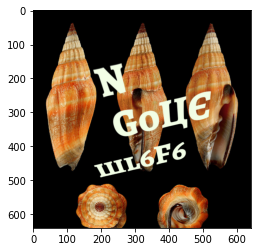

In [ ]:
max_string_length = 100
text_generator = text_generator(alphabet, max_string_length)

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator (
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=60,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

## Bluring

In [ ]:
def image_generator_with_blur(image_generator, min_ksize, max_ksize, some_without_blur = True):
    while True:
        if (min_ksize % 2 == 0):
            min_ksize += 1
        possible_ksize = [i for i in range(min_ksize, max_ksize + 1, 2)]
        low_index = 0
        if some_without_blur:
            low_index = -1
        index = np.random.randint(low = low_index, high = len(possible_ksize))
        image, lines = next(image_generator)
        if index > -1:
            image = cv2.GaussianBlur(image, (possible_ksize[index], possible_ksize[index]), 0)
        yield (image, lines)

In [ ]:
min_ksize = 15
max_ksize = 43
blur_image_generators = [image_generator_with_blur(image_generators[i], min_ksize, max_ksize) for i in range(3)]
image_generators = blur_image_generators
image, lines = next(image_generators[0])
plt.imshow(image)

## Load weights

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'  # 'kurapan'
)
# recognizer.model.load_weights(data_dir + '/weights' + '/last.h5')
recognizer.compile()

In [ ]:
for layer in recognizer.backbone.layers:
    layer.trainable = False

## Train the detector

In [ ]:
num_epochs = 10
weights_dir = data_dir + '/weights'

In [ ]:
detector_batch_size = 4
detector_basepath = os.path.join(weights_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=num_epochs,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

## Train the recognizer

This image contains: EЇ


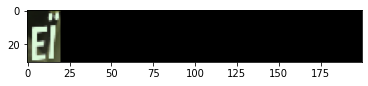

In [ ]:
max_length = 20
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [ ]:
recognition_num_epochs = 100
recognition_batch_size = 32
steps_per_epoch = math.ceil(len(background_splits[0]) / recognition_batch_size) 
validation_steps = math.ceil(len(background_splits[1]) / recognition_batch_size) 

In [ ]:
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=False
    ) for image_generator in recognition_image_generators
]
history = recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=recognition_num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5', save_best_only = True),
      PlotLosses()
    ],
    validation_data=recognition_val_generator,
    validation_steps=validation_steps,
    workers=0
)
recognizer.model.save(f'{recognizer_basepath}_last_epoch.h5')

## Plot losses

In [ ]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.savefig(f'{recognizer_basepath}ThirdIteration.png')
    plt.show()

In [ ]:
plot_metric(history, 'loss')

## Obtaining metrics

In [ ]:
def recognizer_cer_from_generator(recognizer, generator, num_iter, case_sensitive = True):
    """Obtain avarage CER(Character Error Rate)

    Args:
        recognizer: recognizer model
        generator: generator of cropped images, ex. convert_image_generator_to_recognizer_input
        num_iter: number of iterations - aka number of samples
    """
    cer_arr = np.empty([num_iter], dtype=np.float128)
    for i in range(num_iter):
        image, ground_truth_text = next(generator)
        predicted_text = recognizer.recognize(image)
        if (not case_sensitive):
          predicted_text = predicted_text.lower()
          ground_truth_text = ground_truth_text.lower()
        cer_arr[i] = jiwer.cer(ground_truth_text, predicted_text)  
    return np.mean(cer_arr)

In [ ]:
train_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[0], len(background_splits[0]))
print(f'Train CER: {train_cer:.2f}')

In [ ]:
val_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[1], len(background_splits[1]))
print(f'Validation CER: {val_cer:.2f}')

In [ ]:
test_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[2], len(background_splits[2]))
print(f'Test CER: {test_cer:.2f}')

In [ ]:
step_size = 5
num_iterations = 600
pipeline = keras_ocr.pipeline.Pipeline(detector = detector, recognizer = recognizer)
predicted_annotations = {}
ground_truth_annotations = {}

for step in tqdm.tqdm(range(0, num_iterations, step_size)):
    images = []
    for i in range(step_size):
        image, lines = next(image_generators[2])
        predicted_annotations[str(step + i)] = []
        for line in lines:
            text_line = ''.join([line_item[1] for line_item in line])
            last_index = len(line) - 1
            bounding_box = np.array([line[0][0][0], line[last_index][0][1], line[last_index][0][2], line[0][0][3]])
            predicted_annotations[str(step + i)].append(
             {
                 'text': text_line, 'vertices': bounding_box.tolist()
             } 
            )
        images.append(image)
    prediction_groups = pipeline.recognize(images)
    for i, predictions in enumerate(prediction_groups):
        ground_truth_annotations[str(step + i)] = [
            {
                'text': text, 'vertices': box.tolist()
            } for text, box in predictions
        ]

In [ ]:
results, (precision, recall) = keras_ocr.evaluation.score(ground_truth_annotations, predicted_annotations)

In [ ]:
print(f'Samples: {num_iterations}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

## Test images

In [ ]:
# [[l, t], [r, t], [r, b], [l, b]]

def obtain_text(prediction):
    max_height = np.max([abs(bbox[1][1][1] - bbox[1][3][1]) for bbox in prediction])

    pred_sorted = sorted(prediction, key=lambda x: x[1][0][1])

    line_top = pred_sorted[0][1][0][1]
    line = 1
    by_line = []

    for bbox in pred_sorted:
        if bbox[1][0][1] > line_top + max_height - 10:
            line_top = bbox[1][0][1]
            line += 1

        by_line.append((line, bbox))

    by_line_sorted = sorted(by_line)
    line_n = len(set([line for line, bbox in sorted(by_line)]))

    text = ''
    for i in range(1, line_n + 1):
        line_bbox = [bbox[1] for bbox in by_line_sorted if bbox[0] == i]
        line_sorted = sorted(line_bbox, key=lambda x: x[1][0][0])
        
        text += ' '.join([bbox[0] for bbox in line_sorted])
        text += '\n'

    return text

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)

dir = data_dir + '/data/Test_Photos/'

images = [
    keras_ocr.tools.read(path) for path in [
        dir + '1.png',
        dir + '2.png'
    ]
]

prediction_groups = pipeline.recognize(images)

annotation = obtain_text(prediction_groups[0])
print(annotation)

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

## Test video

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 640);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 640; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
fontpath = 'drive/MyDrive/Project/data/fonts/firasanscondensed/FiraSansCondensed-Regular.ttf'

In [ ]:
def get_font(fontpath, box, text):
  font_size = 100
  box_width = box[1][0] - box[0][0]
  desired_text_width = box_width * 0.8
  width = None
  while (width is None or width > box_width) and font_size > 0:
    font = PIL.ImageFont.truetype(fontpath, size = font_size)
    #text_width = font.getlength(text)
    #text_width = font.getbbox(text)
    width, height = font.getsize(text)
    font_size -= 1
  return PIL.ImageFont.truetype(fontpath, size = font_size)

In [ ]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

while True:
    start_time = timeit.default_timer()

    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([640,640,4], dtype=np.uint8)
    prediction = pipeline.recognize([frame_rgb])[0]

    for text, box in prediction:
      bbox_array = cv2.polylines(
                img=bbox_array,
                pts=box[np.newaxis].astype("int32"),
                color=(255, 0, 0, 255),
                thickness=2,
                isClosed=True,
            )
      bbox_array_pil = PIL.Image.fromarray(bbox_array)
      draw = PIL.ImageDraw.Draw(bbox_array_pil)
      draw.text((box[:, 0].min().astype(int), box[:, 1].min().astype(int)), text, font = get_font(fontpath, box, text), fill = (0, 0, 0, 255))
      bbox_array = np.array(bbox_array_pil)
    
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    #latency[i] = timeit.default_timer() - start_time
    #print(timeit.default_timer() - start_time)